# Accuracy of Newton-Cotes

Copyright (C) 2020 Andreas Kloeckner

<details>
<summary>MIT License</summary>
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
</details>

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as pt

A function to make Vandermonde matrices:
    
(Note that the ordering of this matrix matches the convention in our class but *disagrees* with `np.vander`.)

In [2]:
def vander(nodes, ncolumns=None):
    if ncolumns is None:
        ncolumns = len(nodes)
    result = np.empty((len(nodes), ncolumns))
    for i in range(ncolumns):
        result[:, i] = nodes**i
    return result

Fix a set of nodes:

In [3]:
# nodes = [0.5] # Midpoint
# nodes = [0]
#nodes = [0, 1] # Trapezoidal
nodes = [0, 0.5, 1] # Simpson's
#nodes = [0, 1/3, 1]

Find the weights for the Newton-Cotes rule for the given nodes on $[0,1]$:

In [4]:
(a, b) = (0, 1)
nodes = np.array(nodes)
n = len(nodes)

degs = np.arange(n)
rhs = 1/(degs+1)*(b**(degs+1 - a**(degs+1)))
weights = la.solve(vander(nodes).T, rhs)
print(weights)

[0.16666667 0.66666667 0.16666667]


Here is a function and its definite integral from $0$ to $x$:

$$\text{int_f}(x)=\int_0^x f(\xi)d\xi$$

In [5]:
fdeg = 9
def f(x):
    return sum((-x)**i for i in range(fdeg + 1))
def int_f(x):
    return sum(
        (-1)**i*1/(i+1)*(
            (x)**(i+1)-0**(i+1)
            )
        for i in range(fdeg + 1))


Plotted:

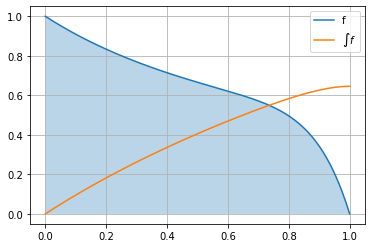

In [6]:
plot_x = np.linspace(0, 1, 200)

pt.plot(plot_x, f(plot_x), label="f")
pt.fill_between(plot_x, 0*plot_x, f(plot_x),alpha=0.3)
pt.plot(plot_x, int_f(plot_x), label="$\int f$")
pt.grid()
pt.legend(loc="best")

This here plots the function, the interpolant, and the area under the interpolant:

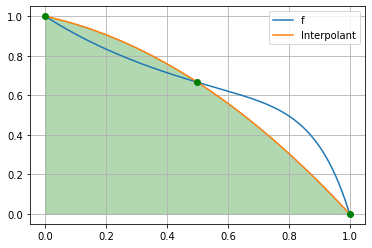

In [7]:
# fix nodes
h = 1
x = nodes * h

# find interpolant
coeffs = la.solve(vander(x), f(x))

# evaluate interpolant
plot_x = np.linspace(0, h, 200)
interpolant = vander(plot_x, len(coeffs)) @ coeffs

# plot
pt.plot(plot_x, f(plot_x), label="f")
pt.plot(plot_x, interpolant, label="Interpolant")
pt.fill_between(plot_x, 0*plot_x, interpolant, alpha=0.3, color="green")
pt.plot(x, f(x), "og")
pt.grid()
pt.legend(loc="best")

Compute the following:

*   The true integral as `true_val` (from `int_f`)
*   The quadrature result as `quad` (using `x` and `weights` and `h`)
*   The error as `err` (the difference of the two)

    (Do not be tempted to compute a relative error--that has one order lower.)

Compare the error for $h=1,0.5,0.25$. What order of accuracy do you observe?

In [8]:
#clear

errors = []

for h in [1, 0.5, 0.25, 0.125, 0.125*0.5]:
    true_val = int_f(h)
    quad = h * weights @ f(h * nodes)
    error = abs(quad - true_val)
    print(h, true_val, quad, error)
    
    errors.append(error)

1 0.6456349206349207 0.6106770833333334 0.0349578373015873
0.5 0.4054346478174603 0.4055010477701823 6.639995272200716e-05
0.25 0.22314353367638967 0.22314811622103056 4.582544640890918e-06
0.125 0.11778303564688754 0.11778322438355342 1.887366658792633e-07
0.0625 0.06062462181642996 0.06062462863932557 6.822895609603918e-09


Estimate the order of accuracy:

We assume that the error depends on the mesh spacings $h$ as
$E(h)\approx C h^p$ for some unknown power $p$.  Taking the $\log$
of this approximate equality reveals a linear function in $p$:
$$
E(h) \approx C h^p \quad \iff \quad \log E(h) \approx \log(C) +
p\log(h).
$$
You can now either do a least-squares fit for $\log C$ and $p$ from
a few data points $(h,E(h))$ (more accurate, more robust), or you
can use just two grid sizes $h_1$ and $h_2$, and estimate the slope:
(less accurate, less robust)
$$
   p \approx \frac{ \log(\frac{E(h_2)}{E(h_1)}) } {\log(\frac{h_2}{h_1})}.
$$
This is called the *empirical order of convergence* or EOC.



In [9]:
for i in range(len(errors)-1):
    print(np.log(errors[i+1]/errors[i])/np.log(1/2))

9.040218004272907
3.856961374376886
4.601702307158235
4.789846769147522
